In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install qiskit_machine_learning
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install qiskit
# %pip install pylatexenc
# %pip install torchvision
# %pip install ipywidgets
# %pip install opencv-python
# %pip install tensorflow


In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from qiskit.circuit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import torch
from torch import nn
from torchvision import transforms
import torch.optim as optim 
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [3]:
dataset_path = f'{path}/chest_xray/chest_xray/train/'
validation_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
validation_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Check data

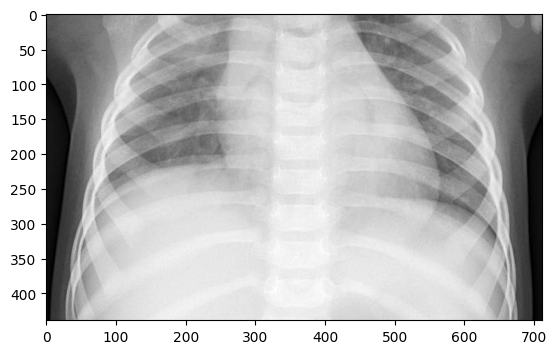

In [4]:
xray_image = cv2.imread(f'{dataset_path}/PNEUMONIA/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

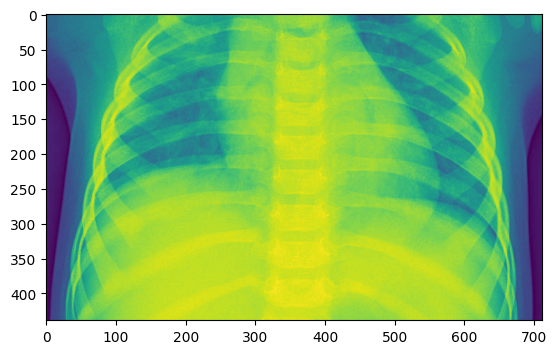

In [5]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Image size

In [6]:
img_size = (128, 128)

#### Categories

In [7]:
categories = ['NORMAL', 'PNEUMONIA']

#### Loading and preprocessing images

In [8]:
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

#### Converting data and labeling to numpy arrays

In [9]:
data = np.array(data)
labels = np.array(labels)

#### Converting labels to one-hot encoded format

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

#### Data transformations

In [11]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

#### Reducing the number of images

In [12]:
X_train = X_train[:1000]
y_train = y_train[:1000]
X_test = X_test[:200]
y_test = y_test[:200]

#### Quantum layer

In [13]:
def create_qnn():
    num_qubits = 3
    feature_map = ZZFeatureMap(feature_dimension=num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True
    )
    return qnn

#### Setting quantum model

In [14]:
class QuantumCNN(nn.Module):
    def __init__(self, quantum_layer):
        super(QuantumCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.quantum_layer = quantum_layer
        
        self.fc1 = nn.Linear(246017, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        quantum_input = torch.rand(x.size(0), 3)
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

#### Initialize the model

In [15]:
num_qubits = 3
quantum_layer = TorchConnector(create_qnn())
quantum_model = QuantumCNN(quantum_layer)

#### Initialize criterion, optimizer

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.001)

#### Training function

In [17]:
def fit_quantum_model(model, X_train, y_train, epochs=10, batch_size=32, patience=5):
    model.train()
    history = {'loss': [], 'accuracy': []}
    best_accuracy = 0
    patience_counter = 0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            acc = (predicted == y_batch.argmax(dim=1)).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

        if avg_epoch_accuracy > best_accuracy:
            best_accuracy = avg_epoch_accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return history

#### Training the model

In [18]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=10)

Epoch [1/10], Loss: 0.9184, Accuracy: 0.7051
Epoch [2/10], Loss: 0.3453, Accuracy: 0.8379
Epoch [3/10], Loss: 0.2013, Accuracy: 0.9141
Epoch [4/10], Loss: 0.1158, Accuracy: 0.9600
Epoch [5/10], Loss: 0.0735, Accuracy: 0.9736
Epoch [6/10], Loss: 0.0622, Accuracy: 0.9785
Epoch [7/10], Loss: 0.0698, Accuracy: 0.9775
Epoch [8/10], Loss: 0.0990, Accuracy: 0.9590
Epoch [9/10], Loss: 0.0219, Accuracy: 0.9951
Epoch [10/10], Loss: 0.0059, Accuracy: 0.9990


#### Plotting accuracy and loss

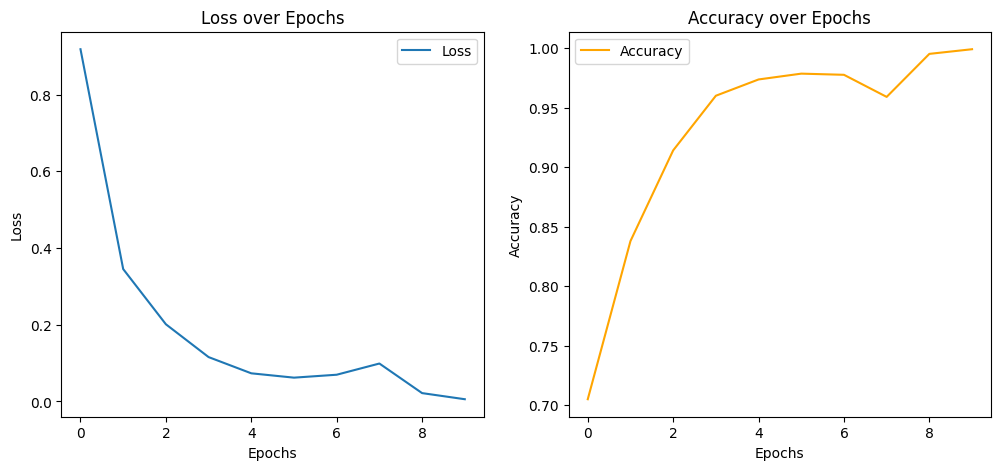

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Preparing the validation data for prediction

In [20]:
quantum_validation_data = []
quantum_validation_labels = []

for label, folder_path in enumerate([validation_path_norm, validation_path_pneu]):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0
            quantum_validation_data.append(img_array)
            quantum_validation_labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

quantum_validation_data = np.array(quantum_validation_data)
quantum_validation_labels = np.array(quantum_validation_labels)

In [21]:
validation_data_tensor = torch.tensor(quantum_validation_data, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape to (N, C, H, W)

#### Run predictions on the validation set

In [22]:
with torch.no_grad():
    predictions = quantum_model(validation_data_tensor)
    predicted_classes = torch.argmax(predictions, axis=1).numpy()

#### Classification Report

In [23]:
print("\nClassification Report:")
print(classification_report(quantum_validation_labels, predicted_classes, target_names=categories))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.23      0.37       234
   PNEUMONIA       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.61      0.59       624
weighted avg       0.80      0.71      0.65       624



In [2]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright